In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder , StandardScaler
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report , confusion_matrix , roc_curve, auc
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import zscore 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import label_binarize
import warnings
from xgboost import XGBClassifier 
import os

warnings.filterwarnings('ignore')

data=pd.read_csv("alzheimers_disease_data.csv")
#data=pd.read_csv("alzheimers_disease_data_improved.csv")


# Visão Geral do Conjunto de Dados

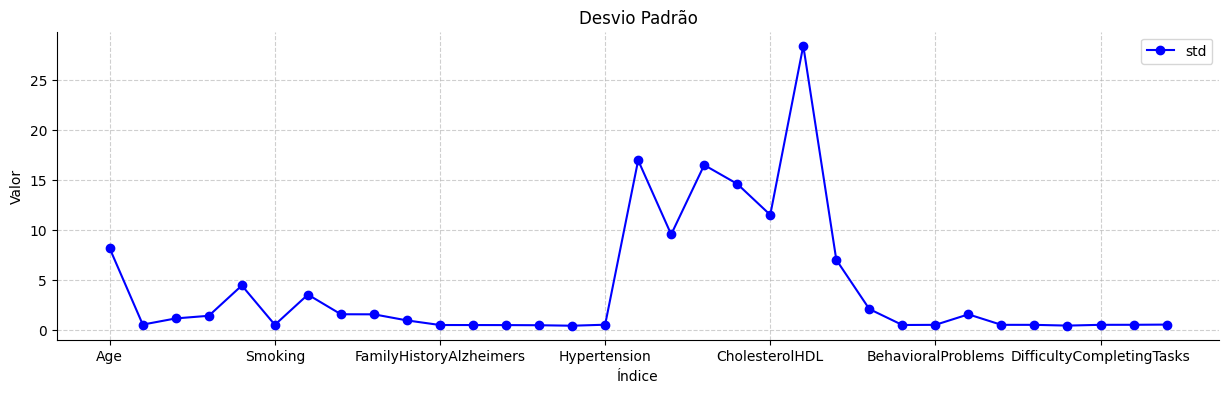

In [2]:
plot = data.drop(columns=['PatientID'])
plot.describe().T.plot(kind='line', y='std', figsize=(15, 4), title='Desvio Padrão', color='b', linestyle='-', marker='o')

plt.xlabel('Índice')
plt.ylabel('Valor')
plt.grid(True, linestyle='--', alpha=0.6)
plt.gca().spines[['top', 'right']].set_visible(False)

plt.show()

In [3]:
colunas_numericas = ['Age', 'BMI', 'AlcoholConsumption', 'PhysicalActivity', 'SystolicBP', 'DiastolicBP', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL', 'CholesterolTriglycerides', 'MMSE']
colunas_categoricas = ['Gender', 'Ethnicity', 'Diagnosis', 'DoctorInCharge']

Contagem de outliers:
Age                          604
BMI                          308
PhysicalActivity              71
DietQuality                   72
SleepQuality                  53
HeadInjury                  1831
SystolicBP                   438
DiastolicBP                  428
CholesterolTotal             108
CholesterolLDL                96
CholesterolHDL               218
CholesterolTriglycerides     405
MMSE                        1028
FunctionalAssessment        1063
ADL                           81
PersonalityChanges          1987
dtype: int64


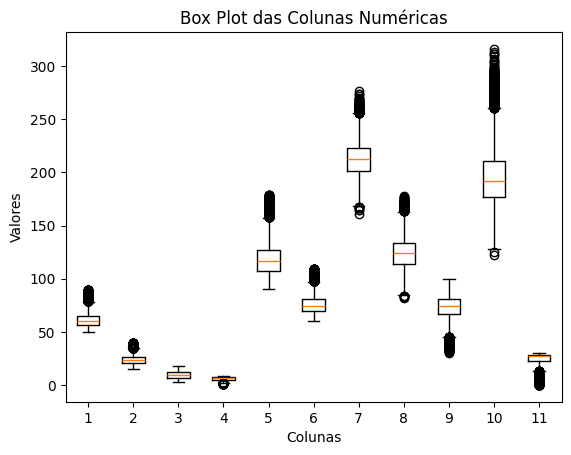

In [4]:
dtcols_numericas = data.select_dtypes(include=['float64', 'int64']).columns
Q1 = data[dtcols_numericas].quantile(0.25)
Q3 = data[dtcols_numericas].quantile(0.75)
IQR = Q3 - Q1
outliers = ((data[dtcols_numericas] < (Q1 - 1.5 * IQR)) | (data[dtcols_numericas] > (Q3 + 1.5 * IQR)))
contagem_outliers = outliers.sum()
contagem_outliers = contagem_outliers[contagem_outliers > 0]

def plot_outliers_boxplot():
    print(f"Contagem de outliers:\n{contagem_outliers}")
    plt.boxplot(data[colunas_numericas])
    plt.title('Box Plot das Colunas Numéricas')
    plt.xlabel('Colunas')
    plt.ylabel('Valores')
    plt.show()
    
plot_outliers_boxplot()

In [5]:
"""import outlier_treatment as ot

colunas_com_outliers = contagem_outliers[contagem_outliers > 0].index

for coluna in colunas_com_outliers:
    print(f"\nTratando outliers na coluna: {coluna}")
    
    # Analisar outliers e obter sugestões
    analysis = ot.suggest_treatment(data, coluna)
    n_outliers = len(analysis['outliers'])
    outlier_percent = (n_outliers / len(data)) * 100
    
    # Condição para não fazer nada se for recomendado manter os outliers
    if outlier_percent < 5 or coluna == 'MMSE':
        print(f"Outliers em {coluna} representam apenas {outlier_percent:.2f}% dos dados. Nenhum tratamento será aplicado.")
        continue
    elif outlier_percent < 20:
        data = ot.impute_by_median(data, coluna)
        print(f"Aplicada imputação por mediana em {coluna}")
    else:
        data = ot.apply_log_transform(data, coluna)
        print(f"Aplicada transformação logarítmica em {coluna}")
    
    # Verificar o resultado
    print(f"Outliers restantes em {coluna}: {len(ot.analyze_outliers(data, coluna)['outliers'])}")

#HeadInjury, CholesterolTotal, CholesterolLDL, FunctionalAssessment, PersonalityChanges

plot_outliers_boxplot()"""

'import outlier_treatment as ot\n\ncolunas_com_outliers = contagem_outliers[contagem_outliers > 0].index\n\nfor coluna in colunas_com_outliers:\n    print(f"\nTratando outliers na coluna: {coluna}")\n    \n    # Analisar outliers e obter sugestões\n    analysis = ot.suggest_treatment(data, coluna)\n    n_outliers = len(analysis[\'outliers\'])\n    outlier_percent = (n_outliers / len(data)) * 100\n    \n    # Condição para não fazer nada se for recomendado manter os outliers\n    if outlier_percent < 5 or coluna == \'MMSE\':\n        print(f"Outliers em {coluna} representam apenas {outlier_percent:.2f}% dos dados. Nenhum tratamento será aplicado.")\n        continue\n    elif outlier_percent < 20:\n        data = ot.impute_by_median(data, coluna)\n        print(f"Aplicada imputação por mediana em {coluna}")\n    else:\n        data = ot.apply_log_transform(data, coluna)\n        print(f"Aplicada transformação logarítmica em {coluna}")\n    \n    # Verificar o resultado\n    print(f"Outl

# Análise Exploratória de Dados (EDA)

# Qual é a distribuição etária dos pacientes?

---

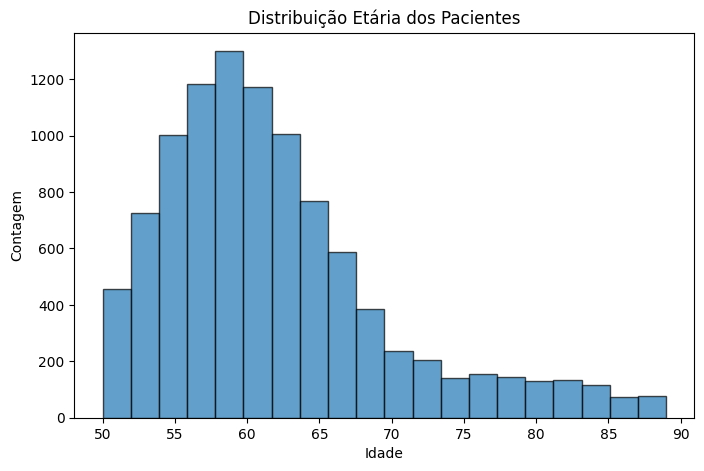

In [6]:
plt.figure(figsize=(8, 5))
plt.hist(data['Age'], bins=20, edgecolor='black', alpha=0.7)
plt.xlabel('Idade')
plt.ylabel('Contagem')
plt.title('Distribuição Etária dos Pacientes')
plt.show()

# Como o Índice de Massa Corporal (IMC) afeta o diagnóstico?

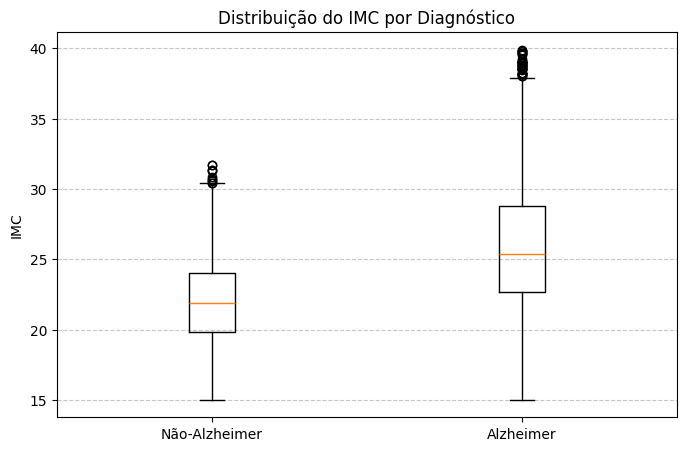

In [7]:
plt.figure(figsize=(8, 5))
plt.boxplot([data[data['Diagnosis'] == 0]['BMI'], data[data['Diagnosis'] == 1]['BMI']],labels=['Não-Alzheimer', 'Alzheimer'])
plt.ylabel('IMC')
plt.title('Distribuição do IMC por Diagnóstico')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Este boxplot compara as distribuições de IMC entre pacientes com Alzheimer e não-Alzheimer.

Ambos os grupos têm medianas semelhantes em torno de 30, com variabilidade igual, sugerindo que não há diferenças significativas no IMC.

---

# Como a taxa de depressão difere entre pacientes com Alzheimer e não-pacientes?

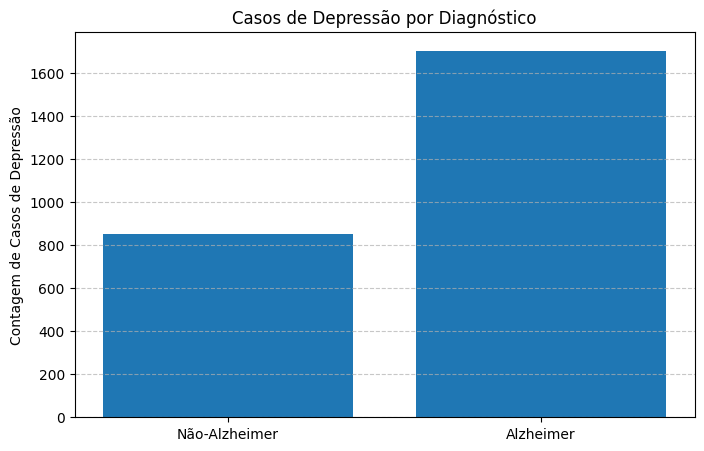

In [8]:
contagem_depressao = data.groupby('Diagnosis')['Depression'].sum()
plt.figure(figsize=(8, 5))
plt.bar(['Não-Alzheimer', 'Alzheimer'], contagem_depressao)
plt.ylabel('Contagem de Casos de Depressão')
plt.title('Casos de Depressão por Diagnóstico')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Há um número significativamente maior de casos de depressão entre pacientes Alzheimer em comparação com pacientes com não-Alzheimer.

Isso sugere que a depressão tem forte ligação com o Alzheimer, mas é necessária uma análise mais aprofundada para entender a relação completa.

------

# Qual é o impacto de ter histórico familiar de Alzheimer no diagnóstico?

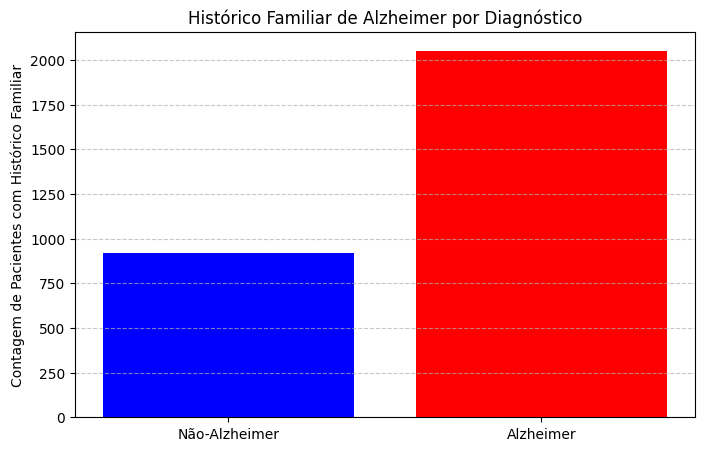

In [9]:
contagem_historico_familiar = data.groupby('Diagnosis')['FamilyHistoryAlzheimers'].sum()
plt.figure(figsize=(8, 5))
plt.bar(['Não-Alzheimer', 'Alzheimer'], contagem_historico_familiar, color=['blue', 'red'])
plt.ylabel('Contagem de Pacientes com Histórico Familiar')
plt.title('Histórico Familiar de Alzheimer por Diagnóstico')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Este gráfico de barras mostra que mais pacientes não-Alzheimer têm histórico familiar
de Alzheimer do que os próprios pacientes com Alzheimer.

Isso sugere que um histórico familiar de Alzheimer pode ser mais comum na população geral.

---

# Qual é a relação entre pressão arterial alta e a doença de Alzheimer?

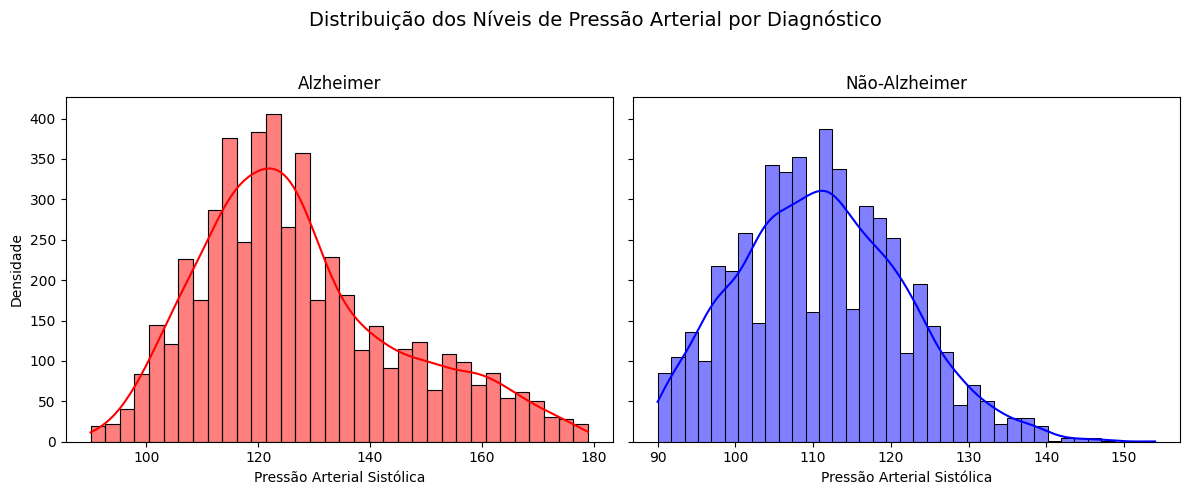

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

sns.histplot(data[data['Diagnosis'] == 1]['SystolicBP'], kde=True, color='red', ax=axes[0])
axes[0].set_title('Alzheimer')
axes[0].set_xlabel('Pressão Arterial Sistólica')
axes[0].set_ylabel('Densidade')

sns.histplot(data[data['Diagnosis'] == 0]['SystolicBP'], kde=True, color='blue', ax=axes[1])
axes[1].set_title('Não-Alzheimer')
axes[1].set_xlabel('Pressão Arterial Sistólica')
axes[1].set_ylabel('')

fig.suptitle('Distribuição dos Níveis de Pressão Arterial por Diagnóstico', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

* Na primeira imagem, observamos a distribuição da pressão arterial sistólica (SystolicBP) exclusivamente para pacientes com Alzheimer. A curva apresenta um viés à direita, com maior concentração de valores entre 125 e 140 mmHg, além de uma cauda estendida para níveis mais altos. Isso indica que muitos desses pacientes apresentam pressão arterial acima da média considerada saudável.

* Na segunda imagem, é apresentada a distribuição da pressão arterial sistólica para indivíduos sem Alzheimer. A curva é mais simétrica e centrada, com a maioria dos valores entre 110 e 125 mmHg, o que sugere uma pressão arterial mais controlada nesse grupo.

* A comparação entre os dois gráficos evidencia que pacientes com Alzheimer tendem a apresentar níveis mais altos de pressão arterial sistólica em relação aos indivíduos sem a doença. Esse padrão sugere uma possível relação entre hipertensão e Alzheimer, embora uma análise estatística mais detalhada seja necessária para estabelecer uma correlação significativa entre os dois fatores.

---

# Existe uma correlação entre queixas de memória e diagnóstico?

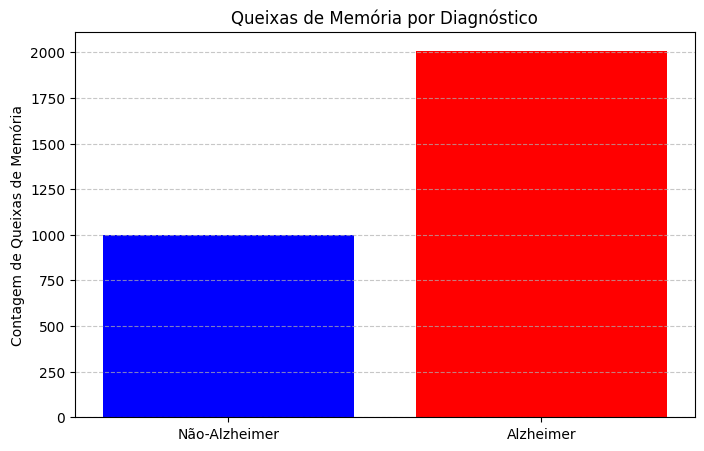

In [11]:
contagem_queixas_memoria = data.groupby('Diagnosis')['MemoryComplaints'].sum()
plt.figure(figsize=(8, 5))
plt.bar(['Não-Alzheimer', 'Alzheimer'], contagem_queixas_memoria, color=['blue', 'red'])
plt.ylabel('Contagem de Queixas de Memória')
plt.title('Queixas de Memória por Diagnóstico')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Pacientes com Alzheimer relatam mais queixas de memória do que indivíduos não-Alzheimer, o que está alinhado com o comprometimento da memória sendo um sintoma chave do Alzheimer.

---

# Como o nível de educação afeta a incidência de Alzheimer?

In [12]:
data['EducationLevel'].unique()

array([4, 3, 2, 1, 0], dtype=int64)

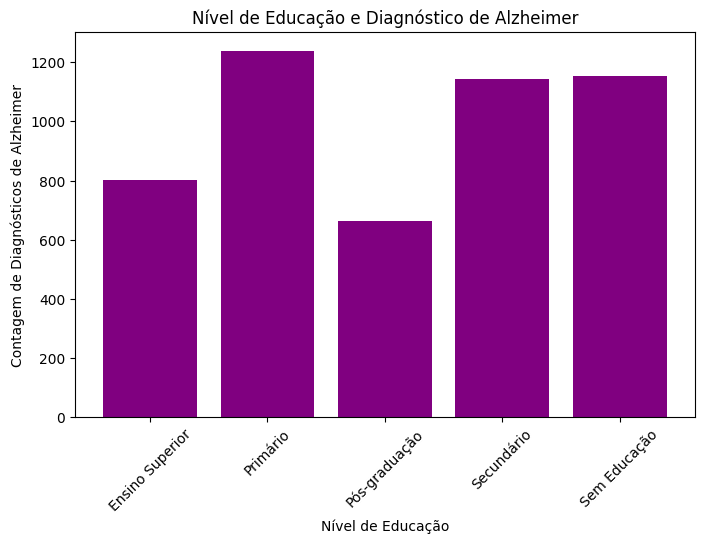

In [13]:
mapeamento_educacao = {
    0: "Sem Educação",
    1: "Primário",
    2: "Secundário",
    3: "Ensino Superior",
    4: "Pós-graduação"}

data_novo = data.copy()

niveis_educacao_unicos = data['EducationLevel'].unique()
for nivel in niveis_educacao_unicos:
    if nivel not in mapeamento_educacao:
        mapeamento_educacao[nivel] = f"Desconhecido ({nivel})"

data_novo['EducationLevelCategory'] = data_novo['EducationLevel'].map(mapeamento_educacao)
contagem_educacao = data_novo.groupby('EducationLevelCategory')['Diagnosis'].sum()

plt.figure(figsize=(8, 5))
plt.bar(contagem_educacao.index, contagem_educacao.values, color='purple')
plt.xlabel('Nível de Educação')
plt.ylabel('Contagem de Diagnósticos de Alzheimer')
plt.title('Nível de Educação e Diagnóstico de Alzheimer')
plt.xticks(rotation=45)
plt.show()

Este gráfico mostra que os diagnósticos de Alzheimer são mais comuns em indivíduos com educação primária ou sem educação, sugerindo uma possível ligação entre níveis mais baixos de educação e maior frequência de Alzheimer.

---

# Qual é a relação entre diabetes e a doença de Alzheimer?

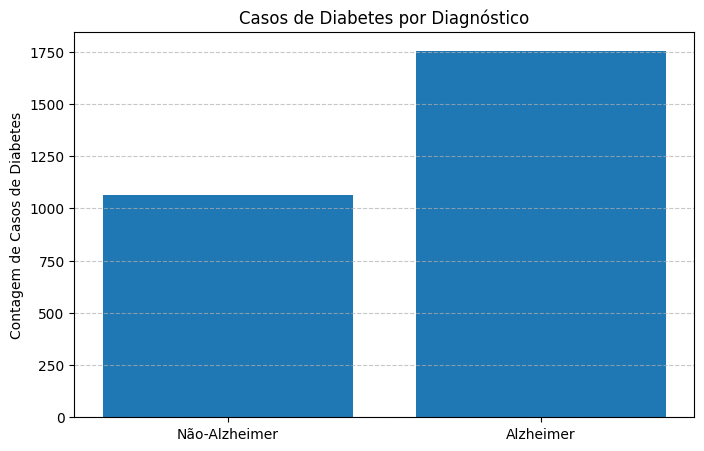

In [14]:
contagem_diabetes = data.groupby('Diagnosis')['Diabetes'].sum()
plt.figure(figsize=(8, 5))
plt.bar(['Não-Alzheimer', 'Alzheimer'], contagem_diabetes)
plt.ylabel('Contagem de Casos de Diabetes')
plt.title('Casos de Diabetes por Diagnóstico')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Mostra que indivíduos não-Alzheimer têm um número significativamente maior de casos de diabetes em comparação com pacientes com Alzheimer.

Isso sugere que o diabetes pode ser mais comum na população geral do que em pacientes com Alzheimer, mas é necessária uma análise mais aprofundada para entender a relação completa.

----

# Quão prevalentes são os problemas comportamentais entre pacientes com Alzheimer?

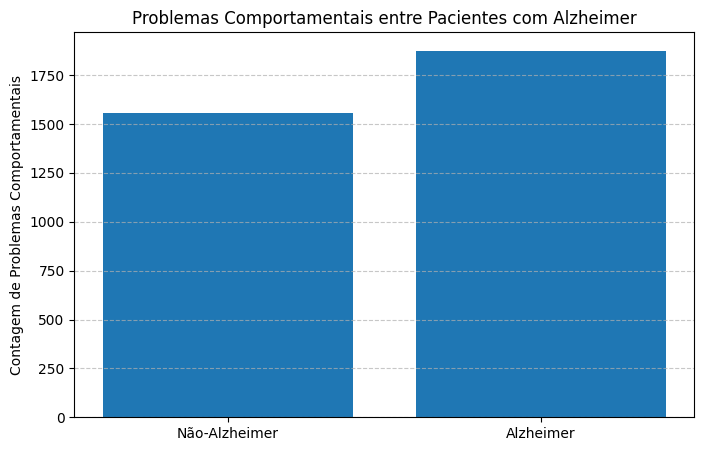

In [15]:
contagem_comportamental = data.groupby('Diagnosis')['BehavioralProblems'].sum()

plt.figure(figsize=(8, 5))
plt.bar(['Não-Alzheimer', 'Alzheimer'], contagem_comportamental)
plt.ylabel('Contagem de Problemas Comportamentais')
plt.title('Problemas Comportamentais entre Pacientes com Alzheimer')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Pacientes com Alzheimer relatam mais problemas comportamentais do que indivíduos não-Alzheimer, o que é comum devido ao declínio cognitivo no Alzheimer.

---

# Quantos pacientes têm diabetes, hipertensão e doença cardiovascular?

In [16]:
doencas = ['Diabetes', 'Hypertension', 'CardiovascularDisease']
fig = make_subplots(rows=1, cols=3, subplot_titles=doencas)

for i, doenca in enumerate(doencas, 1):
    alzheimer = data[data['Diagnosis'] == 1][doenca].value_counts()
    nao_alzheimer = data[data['Diagnosis'] == 0][doenca].value_counts()
    
    com_doenca_alz = alzheimer.get(1, 0)
    com_doenca_nao_alz = nao_alzheimer.get(1, 0)

    fig.add_trace(go.Bar(
        x=["Não-Alzheimer", "Alzheimer"],
        y=[com_doenca_nao_alz, com_doenca_alz],
        name=doenca
    ), row=1, col=i)

fig.update_layout(
    title="Número de Pacientes com Cada Doença por Diagnóstico de Alzheimer",
    template="plotly_dark",
    barmode="group"
)

fig.show()

A maioria dos pacientes tem hipertensão, seguida por doença cardiovascular e diabetes. A prevalência dessas condições é alta entre a população de pacientes.

----

# Qual é a relação entre idade e níveis de colesterol (total, LDL, HDL) entre pacientes com Alzheimer?

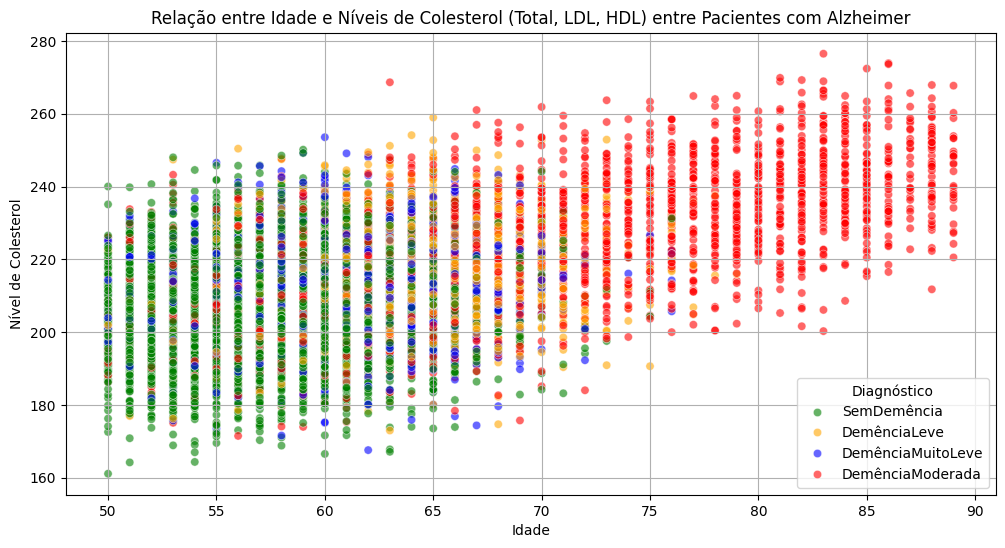

In [17]:
def classify_impairment(mmse):
    if mmse >= 27:
        return 'SemDemência'
    elif 24 <= mmse <= 26:
        return 'DemênciaMuitoLeve'
    elif 19 <= mmse <= 23:
        return 'DemênciaLeve'
    else:
        return 'DemênciaModerada'

data['Impairment'] = data['MMSE'].apply(classify_impairment)

custom_palette = {
    'SemDemência': 'green',
    'DemênciaMuitoLeve': 'blue',
    'DemênciaLeve': 'orange',
    'DemênciaModerada': 'red'
}

plt.figure(figsize=(12, 6))
sns.scatterplot(data=data, x='Age', y='CholesterolTotal', hue='Impairment', palette=custom_palette, alpha=0.6)
plt.title('Relação entre Idade e Níveis de Colesterol (Total, LDL, HDL) entre Pacientes com Alzheimer')
plt.xlabel('Idade')
plt.ylabel('Nível de Colesterol')
plt.legend(title='Diagnóstico')
plt.grid(True)
plt.show()

Não há uma relação clara entre idade e níveis de colesterol (total, LDL, HDL) entre pacientes com Alzheimer.

# Desenvolvimento e Avaliação de Modelos de Machine Learning

In [18]:
colunas_categoricas = ['Gender', 'Ethnicity']
colunas_numericas = ['Age', 'BMI', 'AlcoholConsumption', 'PhysicalActivity', 'SystolicBP', 
                     'DiastolicBP', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL', 
                     'CholesterolTriglycerides', 'FunctionalAssessment', 'ADL']

X = data.drop(columns=['Impairment', 'MMSE', 'Diagnosis', 'PatientID', 'DoctorInCharge'])
y = data['Impairment']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), colunas_numericas),
        ('cat', OneHotEncoder(drop='first'), ['Gender', 'Ethnicity']),
        ('ord', OrdinalEncoder(categories=[[0, 1, 2, 3, 4]]), ['EducationLevel'])
    ])


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
def get_models():

    models = {
        "RandomForest": Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))]),

        "DecisionTree": Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', DecisionTreeClassifier())]),

        "GradientBoosting": Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', GradientBoostingClassifier(random_state=0))]),
    
        "XGBoost": Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42))
        ])
    }
    
    return models


def get_hyperparameter_grids():
    param_grids = {
        "DecisionTree": {
            'classifier__criterion': ['gini', 'entropy'],
            'classifier__max_depth': [None, 5, 10, 20, 30],
            'classifier__min_samples_split': [2, 5, 10],
            'classifier__min_samples_leaf': [1, 2, 4, 6],
            'classifier__max_features': ['sqrt', 'log2', None]
        },

        "GradientBoosting": {
            'classifier__n_estimators': [50, 100, 150, 200],
            'classifier__learning_rate': [0.01, 0.05, 0.1],
            'classifier__max_depth': [3, 4, 5],
            'classifier__min_samples_split': [2, 5, 10],
            'classifier__min_samples_leaf': [1, 2, 4],
            'classifier__subsample': [0.6, 0.75, 0.9, 1.0],
            'classifier__max_features': ['sqrt', 'log2']
        },

        "RandomForest": {
            'classifier__n_estimators': [100, 200, 300, 500],
            'classifier__max_depth': [None, 10, 20, 30, 50],
            'classifier__min_samples_split': [2, 5, 10],
            'classifier__min_samples_leaf': [1, 2, 4],
            'classifier__max_features': ['sqrt', 'log2', 0.8],
            'classifier__bootstrap': [True, False],
            'classifier__class_weight': [None, 'balanced']
        },
        
        "XGBoost": {
            'classifier__n_estimators': [100, 200],
            'classifier__learning_rate': [0.01, 0.05, 0.1],
            'classifier__max_depth': [3, 5, 7],
            'classifier__subsample': [0.6, 0.8, 1.0],
            'classifier__colsample_bytree': [0.6, 0.8, 1.0],
            'classifier__gamma': [0, 0.1, 0.2]
        }
    }
    
    return param_grids

In [21]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

models = get_models()
param_grids = get_hyperparameter_grids()

best_models = {}
model_accuracies = {}

for model_name, model in models.items():
    print(f"\nTreinando {model_name}...")
    
    if model_name in param_grids:  
        search = RandomizedSearchCV(model, param_distributions=param_grids[model_name], n_iter=20,
            cv=5, scoring='accuracy', n_jobs=-1, verbose=1, random_state=42, error_score='raise')  # For debugging
        search.fit(X_train, y_train_encoded)  # Use encoded y_train
        best_models[model_name] = search.best_estimator_
        print(f"Melhores Parâmetros {model_name}: {search.best_params_}")
    else: 
        model.fit(X_train, y_train_encoded)  # Use encoded y_train
        best_models[model_name] = model

    y_pred = best_models[model_name].predict(X_test)
    
    # Convert predictions back to original labels for reporting
    y_pred_labels = label_encoder.inverse_transform(y_pred)
    
    acc = accuracy_score(y_test, y_pred_labels)  # Use original y_test for accuracy
    model_accuracies[model_name] = acc

    print(f"\nRelatório de Classificação {model_name}:")
    print(classification_report(y_test, y_pred_labels))

print("\nAcurácia dos modelos:")
for model_name, acc in model_accuracies.items():
    print(f"{model_name}: {acc*100:.2f}%")


Treinando RandomForest...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Melhores Parâmetros RandomForest: {'classifier__n_estimators': 300, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 4, 'classifier__max_features': 'sqrt', 'classifier__max_depth': 50, 'classifier__class_weight': None, 'classifier__bootstrap': True}

Relatório de Classificação RandomForest:
                   precision    recall  f1-score   support

     DemênciaLeve       0.81      0.92      0.86       220
 DemênciaModerada       0.98      0.61      0.76       500
DemênciaMuitoLeve       0.63      0.84      0.72       270
      SemDemência       0.91      0.97      0.94      1010

         accuracy                           0.86      2000
        macro avg       0.83      0.84      0.82      2000
     weighted avg       0.88      0.86      0.85      2000


Treinando DecisionTree...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Melhores Parâmetros DecisionTree: {

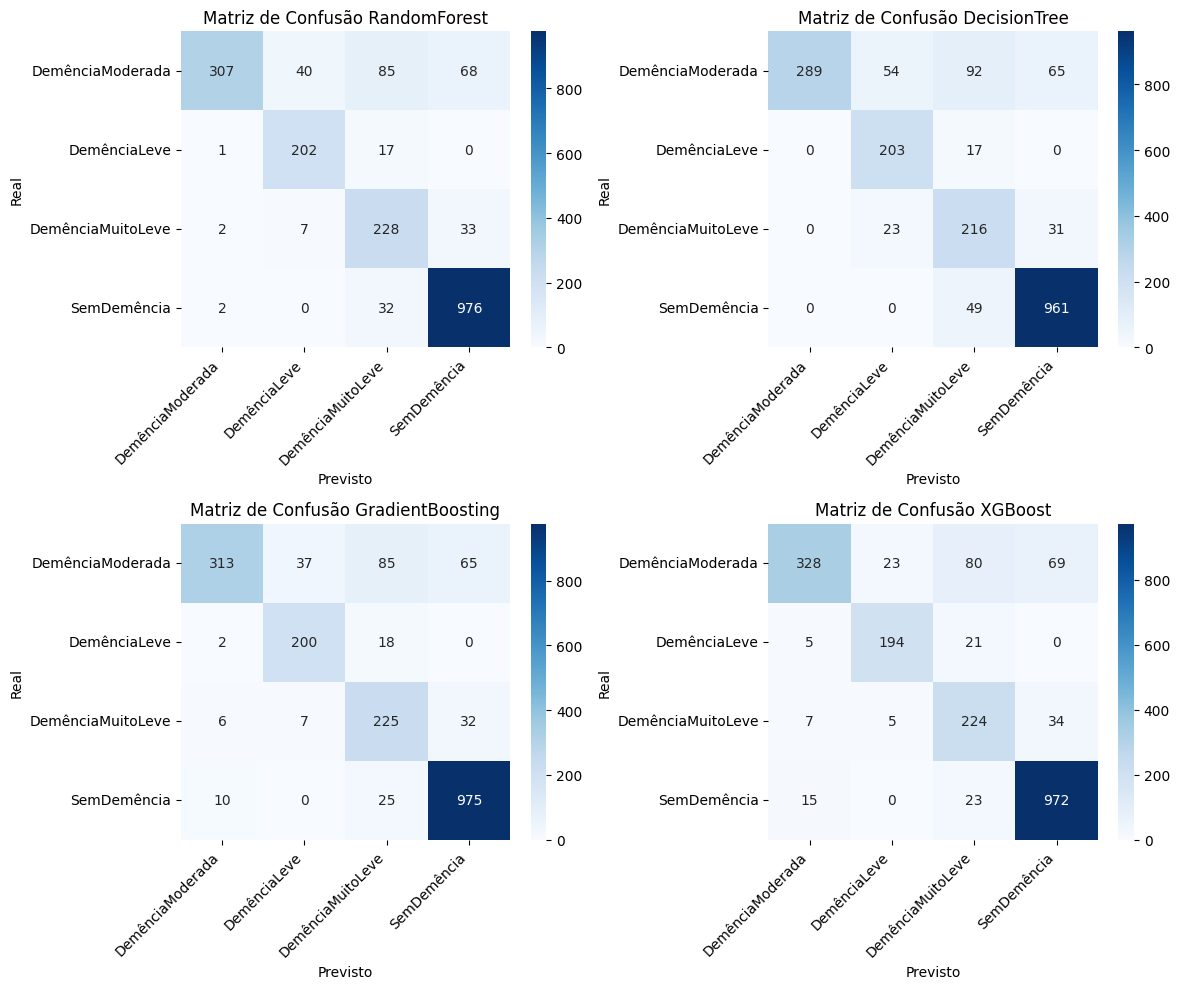

In [22]:
import numpy as np

# Nova ordem das classes desejada
nova_ordem = ['DemênciaModerada', 'DemênciaLeve', 'DemênciaMuitoLeve', 'SemDemência']

# Mapeia o índice original para a nova ordem
nova_ordem_idx = [list(label_encoder.classes_).index(classe) for classe in nova_ordem]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
nomes_modelos = ['RandomForest', 'DecisionTree', 'GradientBoosting', 'XGBoost']

model_positions = {
    'RandomForest': (0, 0),
    'DecisionTree': (0, 1),
    'GradientBoosting': (1, 0),
    'XGBoost': (1, 1)
}

for model_name in nomes_modelos:
    row, col = model_positions[model_name]
    
    y_pred = best_models[model_name].predict(X_test)
    matriz_confusao = confusion_matrix(y_test_encoded, y_pred)

    # Reordena as linhas e colunas da matriz de confusão
    matriz_reordenada = matriz_confusao[np.ix_(nova_ordem_idx, nova_ordem_idx)]
    
    sns.heatmap(matriz_reordenada, annot=True, fmt='d', cmap='Blues', ax=axes[row, col])
    axes[row, col].set_title(f"Matriz de Confusão {model_name}")
    axes[row, col].set_xlabel("Previsto")
    axes[row, col].set_ylabel("Real")

    axes[row, col].set_xticklabels(nova_ordem, rotation=45, ha='right')
    axes[row, col].set_yticklabels(nova_ordem, rotation=0)

plt.tight_layout()
plt.show()


In [23]:
import joblib
import os

os.makedirs("models", exist_ok=True)

for nome, modelo in best_models.items():
    caminho = f"models/{nome}.joblib"
    joblib.dump(modelo, caminho)
    print(f"Modelo {nome} salvo em: {caminho}")
    
#joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoder, 'models/label_encoder.pkl')

Modelo RandomForest salvo em: models/RandomForest.joblib
Modelo DecisionTree salvo em: models/DecisionTree.joblib
Modelo GradientBoosting salvo em: models/GradientBoosting.joblib
Modelo XGBoost salvo em: models/XGBoost.joblib


['models/label_encoder.pkl']

# Curvas ROC

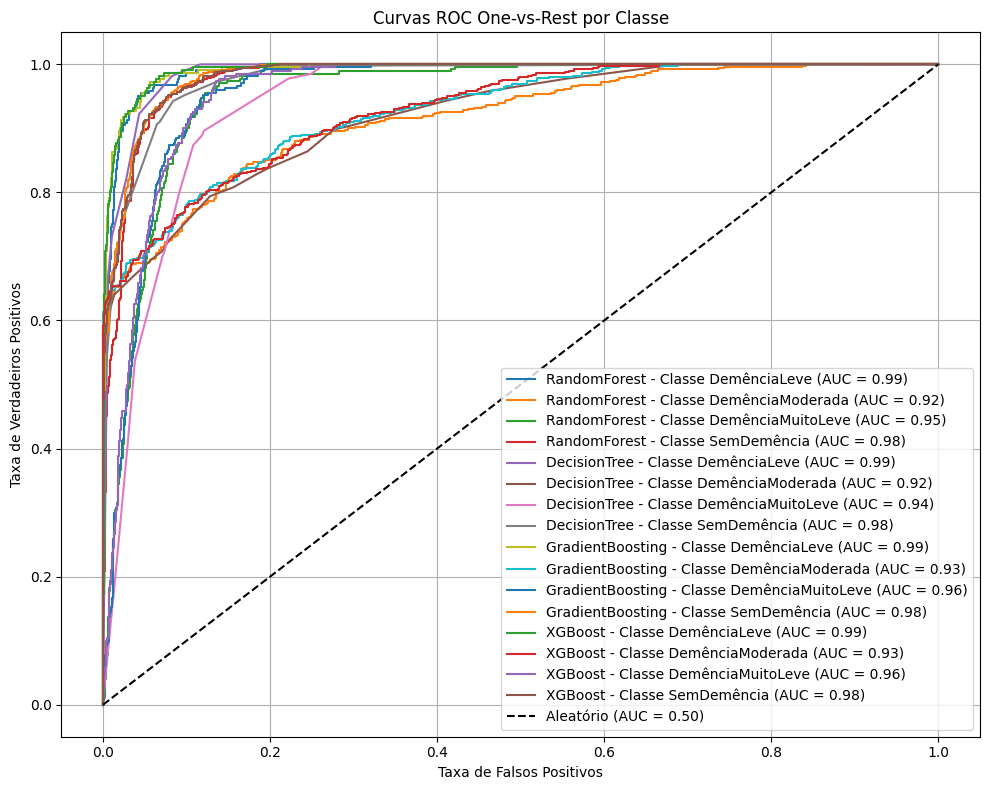

In [24]:
classes = sorted(y_test.unique())
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = y_test_bin.shape[1]

plt.figure(figsize=(10, 8))

nomes_modelos = list(best_models.keys())

for model_name in nomes_modelos:
    classifier = best_models[model_name]
    
    if hasattr(classifier, "predict_proba"):
        y_score = classifier.predict_proba(X_test)
    elif hasattr(classifier, "decision_function"):
        y_score = classifier.decision_function(X_test)
    else:
        print(f"{model_name} não suporta predict_proba ou decision_function. Ignorado.")
        continue

    if y_score.shape[1] != n_classes:
        print(f"{model_name}: Número de classes incompatível. Ignorado.")
        continue

    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{model_name} - Classe {classes[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--", label="Aleatório (AUC = 0.50)")
plt.xlabel("Taxa de Falsos Positivos")
plt.ylabel("Taxa de Verdadeiros Positivos")
plt.title("Curvas ROC One-vs-Rest por Classe")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


1. Pontuações AUC (Área Sob a Curva):

    * Random Forest (AUC = 0.95) e Gradient Boosting (AUC = 0.95) têm o melhor desempenho, indicando forte capacidade de classificação.
  
    * Decision Tree (AUC = 0.93) tem desempenho ligeiramente pior, mas ainda é um bom classificador.

2. Interpretação da Curva ROC:

    * Um modelo com AUC próxima a 1 é um forte classificador.
  
    * As curvas de Random Forest e Gradient Boosting estão mais próximas do canto superior esquerdo, mostrando melhor classificação com menos falsos positivos.

    * A curva de Decision Tree está ligeiramente abaixo, significando que tem poder preditivo um pouco menor.

3. Comparação com a Linha de Base (Linha Tracejada)

    * A linha diagonal tracejada representa um classificador aleatório (AUC = 0.5), que faria previsões por acaso.
  
    * Como todos os modelos estão bem acima dessa linha, eles fornecem valor preditivo significativo.

# **Conclusão sobre as Curvas ROC**

* Os modelos Random Forest e Gradient Boosting superam o modelo Decision Tree em termos de AUC e qualidade de classificação.
  
* Quanto maior a AUC, melhor o modelo em distinguir entre as classes.

* Se a eficiência for uma prioridade, o Gradient Boosting pode ser preferido por seu equilíbrio entre precisão e complexidade.